In [1]:
"""
Imports
"""
import json, time
import numpy as np
import pandas as pd

import sys
rootPath = '../../../'
sys.path.insert(0, rootPath+'Architecture/')
from groundTruth import GroundTruth
from statistics import Statistics
from dataManagement import Scaler

from ods import Sample, ODS
from multiprocessing import Process, Queue
np.seterr(invalid='ignore')

import scipy.stats as st

In [2]:
radius_factor_type = 'dynamic'
scaler_type = 'StandardScaler'

In [3]:
def get_features_node(node, rootPath):
    features_node = json.loads(open(rootPath+'features_node.json').read())
    features_to_use = features_node[node]['DataPlane']+features_node[node]['ControlPlane']
    features_to_use = features_to_use+['time']
    len(features_to_use)
    return features_to_use

def read_data(datasets):
    
    result = {}
    
    for dataset in datasets:

        config = json.loads(open(rootPath+'configuration.json').read())['datasets'][dataset]
        
        print(dataset)
        
        for node in config['nodes']:
            features_node = get_features_node(node, rootPath)                                       
            df = pd.read_csv(rootPath + config['directory']+node+config['filename'],
                 low_memory=False, dtype='float64', compression='gzip')
            df = df[features_node]
        
            times = df['time']//1e9
            times = times.astype('int')
            df.drop(['time'], axis=1, inplace=True)  
                        
            sampleSkip = 30
            
            scaler = Scaler(scaler_type)
            dfNormalized = scaler.normalize(df)
            print('Dataset: {} - Node: {} - Shape: {}'.format(dataset,node,df.shape))            
            
            bufferDF = dfNormalized[0:sampleSkip]
            testDF = dfNormalized[sampleSkip:]
            
            node_result = {
                'times':times,
                'buffer':bufferDF,
                'test':testDF,
                'dataset':dataset,
                'node':node,
                'sampleSkip':sampleSkip
            }
            
            result[dataset+'_'+node] = node_result
            
    return result

In [4]:
datasets = ['BGP_testbed_2', 'BGP_testbed_3']
data = read_data(datasets)

BGP_testbed_2
Dataset: BGP_testbed_2 - Node: leaf1 - Shape: (666, 54)
Dataset: BGP_testbed_2 - Node: leaf2 - Shape: (672, 54)
Dataset: BGP_testbed_2 - Node: leaf3 - Shape: (671, 54)
Dataset: BGP_testbed_2 - Node: leaf5 - Shape: (674, 54)
Dataset: BGP_testbed_2 - Node: leaf6 - Shape: (672, 54)
Dataset: BGP_testbed_2 - Node: leaf7 - Shape: (677, 54)
Dataset: BGP_testbed_2 - Node: leaf8 - Shape: (676, 58)
Dataset: BGP_testbed_2 - Node: spine1 - Shape: (664, 74)
Dataset: BGP_testbed_2 - Node: spine2 - Shape: (663, 74)
Dataset: BGP_testbed_2 - Node: spine3 - Shape: (666, 74)
Dataset: BGP_testbed_2 - Node: spine4 - Shape: (664, 74)
BGP_testbed_3
Dataset: BGP_testbed_3 - Node: leaf1 - Shape: (418, 54)
Dataset: BGP_testbed_3 - Node: leaf2 - Shape: (419, 54)
Dataset: BGP_testbed_3 - Node: leaf3 - Shape: (419, 54)
Dataset: BGP_testbed_3 - Node: leaf5 - Shape: (419, 54)
Dataset: BGP_testbed_3 - Node: leaf6 - Shape: (419, 54)
Dataset: BGP_testbed_3 - Node: leaf7 - Shape: (422, 54)
Dataset: BGP_tes

In [10]:
lamb = 0.125
beta = 0.4

def run_ods_node(node_data, k_std, queue):
    print('Running dataset: {} - node: {} - kstd: {}'.format(node_data['dataset'],node_data['node'],k_std))
    st = Statistics(node_data['dataset'], rootPath)
    times = node_data['times']
    
    bufferDF = node_data['buffer']
    testDF = node_data['test']
    
    ods = ODS(
        lamb = lamb,\
        epsilon = radius_factor_type,\
        beta = beta,\
        mu = 'auto',\
        startingBuffer=bufferDF.values,\
        tp='auto',\
        k_std=k_std)
    
    ods.runInitialization()
    
    startingSimulation = time.time()
    outputCurrentNode = []
    for sampleNumber in range(len(testDF)):
        sample = testDF.iloc[sampleNumber]
        result = ods.runOnNewSample(Sample(sample.values, times.iloc[sampleNumber]))[0]
        outputCurrentNode.append(result)
    endSimulation = time.time() - startingSimulation

    
    ods_result = pd.Series([False] * node_data['sampleSkip'] + outputCurrentNode)

    nodeResults = []
    for KT in range(1, 2):

        st.getScores(times, ods_result, KT)
        nodeResults.extend([st.gt.Precision, st.gt.Recall, st.gt.FPR])
        
    queue.put([node_data['dataset']+'_'+node_data['node']+'_'+str(k_std), nodeResults])        
        
    return

In [11]:
k_std_range = np.arange(1.0,3.6, 0.1)
k_std_range

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5])

In [12]:
def get_fscore(row,beta=0.5):
    precision = row[0]
    recall = row[1]
    
    if np.isnan(precision):
        return 0
    
    if recall == 0:
        return 0
    
    return (1+beta*beta)*precision*recall/(beta*beta*precision+recall)

def get_mean_conf_interval(df):
    res = {}
    
    res['avg_prec'] = df['pre'].mean()
    res['avg_rec'] = df['rec'].mean()
    res['avg_fscore'] = df['f_score'].mean()
    res['avg_fprate'] = df['fpr'].mean()
        
    res['ci_prec_low'] = res['avg_prec'] - st.t.interval(0.95, len(df['pre'].dropna())-1, loc=df['pre'].dropna().mean(), scale=st.sem(df['pre'].dropna()))[0]
    res['ci_prec_high'] = st.t.interval(0.95, len(df['pre'].dropna())-1, loc=df['pre'].dropna().mean(), scale=st.sem(df['pre'].dropna()))[1] - res['avg_prec']
    
    res['ci_rec_low'] = res['avg_rec'] - st.t.interval(0.95, len(df['rec'])-1, loc=df['rec'].mean(), scale=st.sem(df['rec']))[0] 
    res['ci_rec_high'] = st.t.interval(0.95, len(df['rec'])-1, loc=df['rec'].mean(), scale=st.sem(df['rec']))[1] - res['avg_rec'] 

    res['ci_fscore_low'] = res['avg_fscore'] - st.t.interval(0.95, len(df['f_score'])-1, loc=df['f_score'].mean(), scale=st.sem(df['f_score']))[0] 
    res['ci_fscore_high'] = st.t.interval(0.95, len(df['f_score'])-1, loc=df['f_score'].mean(), scale=st.sem(df['f_score']))[1] - res['avg_fscore'] 
    
    res['ci_fprate_low'] = res['avg_fprate'] - st.t.interval(0.95, len(df['fpr'])-1, loc=df['fpr'].mean(), scale=st.sem(df['fpr']))[0] 
    res['ci_fprate_high'] = st.t.interval(0.95, len(df['fpr'])-1, loc=df['fpr'].mean(), scale=st.sem(df['fpr']))[1] - res['avg_fprate'] 
        
    
    return pd.Series(res, index=['avg_prec', 'avg_rec', 'avg_fscore','avg_fprate',
                                 'ci_prec_low', 'ci_prec_high',
                                 'ci_rec_low', 'ci_rec_high', 
                                 'ci_fscore_low', 'ci_fscore_high',
                                 'ci_fprate_low', 'ci_fprate_high'])

In [13]:
q = Queue()
jobs = []

totalProcesses = len(k_std_range) * len(data)
maxProcesses = 8

out_results = {}
currentProcess = 0
activeProcesses = 0

for k_std in k_std_range:
    for name_current_data, current_data in data.items():
        p = Process(target=run_ods_node, args=(current_data, k_std, q),)
        jobs.append(p)
    
    
while currentProcess < totalProcesses:
    if (activeProcesses < maxProcesses) and len(jobs)>0:
        p=jobs.pop()
        p.start()
        activeProcesses+=1
    else:
        res = q.get()
        if res is None:
            time.sleep(0.00000001)
            continue
        else:
            out_results[res[0]] = res[1]
            currentProcess+=1
            activeProcesses-=1

    time.sleep(0.00000001)
print('Done')

res = []
labels = []
lamb_value = []
for x, y in out_results.items():
    res.append(np.append(y,float(x.split('_')[4])))
    labels.append(x)

df_full = pd.DataFrame(res, index=labels, columns=['pre', 'rec', 'fpr', 'k_std'])
df_full['f_score'] = df_full.apply(lambda row: get_fscore(row), axis=1)

radius_mean_and_conf = df_full.groupby('k_std').apply(get_mean_conf_interval)    

Running dataset: BGP_testbed_3 - node: spine4 - kstd: 3.500000000000002
Running dataset: BGP_testbed_3 - node: spine3 - kstd: 3.500000000000002
Running dataset: BGP_testbed_3 - node: spine2 - kstd: 3.500000000000002
Running dataset: BGP_testbed_3 - node: spine1 - kstd: 3.500000000000002
Running dataset: BGP_testbed_3 - node: leaf8 - kstd: 3.500000000000002
Running dataset: BGP_testbed_3 - node: leaf7 - kstd: 3.500000000000002
Running dataset: BGP_testbed_3 - node: leaf6 - kstd: 3.500000000000002
Running dataset: BGP_testbed_3 - node: leaf5 - kstd: 3.500000000000002
Running dataset: BGP_testbed_3 - node: leaf3 - kstd: 3.500000000000002
Running dataset: BGP_testbed_3 - node: leaf2 - kstd: 3.500000000000002
Running dataset: BGP_testbed_3 - node: leaf1 - kstd: 3.500000000000002
Running dataset: BGP_testbed_2 - node: spine4 - kstd: 3.500000000000002
Running dataset: BGP_testbed_2 - node: spine3 - kstd: 3.500000000000002
Running dataset: BGP_testbed_2 - node: spine2 - kstd: 3.500000000000002

Running dataset: BGP_testbed_3 - node: leaf8 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_3 - node: leaf7 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_3 - node: leaf6 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_3 - node: leaf5 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_3 - node: leaf3 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_3 - node: leaf2 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_3 - node: leaf1 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_2 - node: spine4 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_2 - node: spine3 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_2 - node: spine2 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_2 - node: spine1 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_2 - node: leaf8 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_2 - node: leaf7 - kstd: 3.0000000000000018
Running dataset: BGP_testbed_2 - node: leaf6 - kstd: 3.00000

Running dataset: BGP_testbed_3 - node: leaf5 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_3 - node: leaf3 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_3 - node: leaf2 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_3 - node: leaf1 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_2 - node: spine4 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_2 - node: spine3 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_2 - node: spine2 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_2 - node: spine1 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_2 - node: leaf8 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_2 - node: leaf7 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_2 - node: leaf6 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_2 - node: leaf5 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_2 - node: leaf3 - kstd: 2.5000000000000013
Running dataset: BGP_testbed_2 - node: leaf2 - kstd: 2.50000

Running dataset: BGP_testbed_2 - node: spine4 - kstd: 2.000000000000001
Running dataset: BGP_testbed_2 - node: spine3 - kstd: 2.000000000000001
Running dataset: BGP_testbed_2 - node: spine2 - kstd: 2.000000000000001
Running dataset: BGP_testbed_2 - node: spine1 - kstd: 2.000000000000001
Running dataset: BGP_testbed_2 - node: leaf8 - kstd: 2.000000000000001
Running dataset: BGP_testbed_2 - node: leaf7 - kstd: 2.000000000000001
Running dataset: BGP_testbed_2 - node: leaf6 - kstd: 2.000000000000001
Running dataset: BGP_testbed_2 - node: leaf5 - kstd: 2.000000000000001
Running dataset: BGP_testbed_2 - node: leaf3 - kstd: 2.000000000000001
Running dataset: BGP_testbed_2 - node: leaf2 - kstd: 2.000000000000001
Running dataset: BGP_testbed_2 - node: leaf1 - kstd: 2.000000000000001
Running dataset: BGP_testbed_3 - node: spine4 - kstd: 1.9000000000000008
Running dataset: BGP_testbed_3 - node: spine3 - kstd: 1.9000000000000008
Running dataset: BGP_testbed_3 - node: spine2 - kstd: 1.9000000000000

Running dataset: BGP_testbed_2 - node: spine1 - kstd: 1.5000000000000004
Running dataset: BGP_testbed_2 - node: leaf8 - kstd: 1.5000000000000004
Running dataset: BGP_testbed_2 - node: leaf7 - kstd: 1.5000000000000004
Running dataset: BGP_testbed_2 - node: leaf6 - kstd: 1.5000000000000004
Running dataset: BGP_testbed_2 - node: leaf5 - kstd: 1.5000000000000004
Running dataset: BGP_testbed_2 - node: leaf3 - kstd: 1.5000000000000004
Running dataset: BGP_testbed_2 - node: leaf2 - kstd: 1.5000000000000004
Running dataset: BGP_testbed_2 - node: leaf1 - kstd: 1.5000000000000004
Running dataset: BGP_testbed_3 - node: spine4 - kstd: 1.4000000000000004
Running dataset: BGP_testbed_3 - node: spine3 - kstd: 1.4000000000000004
Running dataset: BGP_testbed_3 - node: spine2 - kstd: 1.4000000000000004
Running dataset: BGP_testbed_3 - node: spine1 - kstd: 1.4000000000000004
Running dataset: BGP_testbed_3 - node: leaf8 - kstd: 1.4000000000000004
Running dataset: BGP_testbed_3 - node: leaf7 - kstd: 1.4000

In [15]:
radius_mean_and_conf = radius_mean_and_conf.fillna(0)
radius_mean_and_conf

,avg_prec,avg_rec,avg_fscore,avg_fprate,ci_prec_low,ci_prec_high,ci_rec_low,ci_rec_high,ci_fscore_low,ci_fscore_high,ci_fprate_low,ci_fprate_high
k_std,,,,,,,,,,,,
1.0,0.217796,0.987013,0.248997,0.203780,0.085765,0.085765,0.018637,0.018637,0.089832,0.089832,0.057714,0.057714
1.1,0.253636,0.963474,0.281494,0.188769,0.110375,0.110375,0.027151,0.027151,0.109178,0.109178,0.057046,0.057046
1.2,0.320443,0.963474,0.346682,0.158305,0.133730,0.133730,0.027151,0.027151,0.130317,0.130317,0.055477,0.055477
1.3,0.349608,0.951299,0.375029,0.142236,0.139421,0.139421,0.029339,0.029339,0.134830,0.134830,0.053757,0.053757
1.4,0.406862,0.939935,0.435228,0.105610,0.138757,0.138757,0.034515,0.034515,0.134507,0.134507,0.045585,0.045585
1.5,0.475603,0.933442,0.502838,0.082795,0.147008,0.147008,0.034828,0.034828,0.141990,0.141990,0.041485,0.041485
1.6,0.540025,0.915584,0.560285,0.064707,0.158219,0.158219,0.033784,0.033784,0.150049,0.150049,0.034457,0.034457
1.7,0.556092,0.898539,0.569169,0.065494,0.160544,0.160544,0.045802,0.045802,0.148538,0.148538,0.036987,0.036987
1.8,0.662773,0.886364,0.660858,0.056782,0.166754,0.166754,0.050699,0.050699,0.152310,0.152310,0.039030,0.039030


In [16]:
def group_data_radius_factor(df):
    res = {}
    res['f_score'] = df['f_score'].values
    res['precision'] =  df['pre'].values
    res['recall'] = df['rec'].values
    
    return pd.Series(res, index=['f_score', 'precision', 'recall'])
    
    

In [17]:
res = df_full.groupby('k_std').apply(group_data_radius_factor)

precision = res['precision'].values
recall = res['recall'].values
fscore = res['f_score'].values

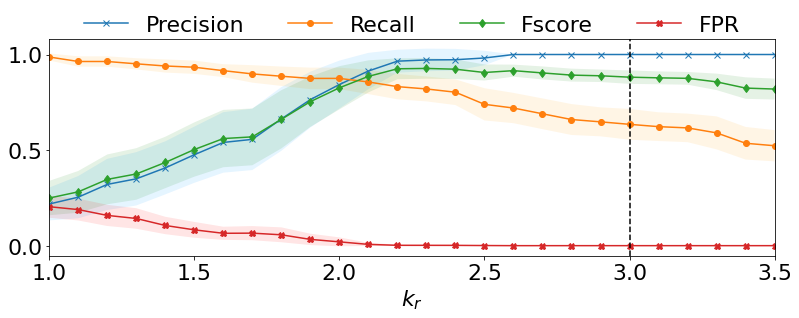

In [18]:
import matplotlib.pyplot as plt


fontsizeLegend = 22
fontsizeticks = 22
fontsizeLabel = 22

labels = {
    "prec":"Precision",
    "rec":"Recall",
    "fscore":"Fscore",
    "fprate":"FPR"
}

markers = {
    "prec":"x",
    "rec":"o",
    "fscore":"d",
    "fprate":"X"
}

def plot_kpi_conf_interval(ax, kpi):
    
    kpi_name = 'avg_'+kpi
    kpi_name_low = 'ci_'+kpi+'_low'
    kpi_name_high = 'ci_'+kpi+'_high'
    
    colors = {
        'prec': '#089FFF',
        'rec': 'orange',
        'fscore': 'green',
        'fprate': 'red'
    }
    
    ax.plot(radius_mean_and_conf[kpi_name].index,
            radius_mean_and_conf[kpi_name],
            label=labels[kpi],
            marker=markers[kpi])
    
    ax.fill_between(radius_mean_and_conf[kpi_name].index, 
                    radius_mean_and_conf[kpi_name]-radius_mean_and_conf[kpi_name_low], 
                    radius_mean_and_conf[kpi_name]+radius_mean_and_conf[kpi_name_high],
                    alpha=0.1, facecolor=colors[kpi],
                    linewidth=4, linestyle='dashdot', antialiased=True)    


fig, ax = plt.subplots(1, figsize=(13,4), sharex=True)

kpi = 'prec'
plot_kpi_conf_interval(ax, kpi)

kpi = 'rec'
plot_kpi_conf_interval(ax, kpi)

kpi = 'fscore'
plot_kpi_conf_interval(ax, kpi)

kpi = 'fprate'
plot_kpi_conf_interval(ax, kpi)

ax.set_xlim((1,3.5))
# ax.set_ylim((0.5,1.1))

ax.tick_params(axis='both', which='major', labelsize=fontsizeticks)
ax.tick_params(axis='both', which='minor', labelsize=fontsizeticks)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
              ncol=5, fancybox=False, shadow=False, fontsize=fontsizeLegend, frameon=False)
ax.set_xlabel(r'$k_{r}$', fontsize=fontsizeLabel)

ax.axvline(x=3, linestyle='--', c='k')

plt.savefig('Figures/k_std.pdf', bbox_inches='tight', pad_inches=0)